In [3]:
# [Cell 1] Installation and Imports
# Install the yfinance library (for real-time data)
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set display format to two decimal places
pd.options.display.float_format = '{:,.2f}'.format
print("Environment setup complete! Ready for calculations.")

Environment setup complete! Ready for calculations.


# **Step 1: Core Valuation Assumptions**

This step establishes the foundational input parameters for the **Discounted Cash Flow (DCF)** model. Building on the qualitative analysis in the **Future Performance** section, we translate strategic judgments into concrete numerical assumptions:

* **Corporate Tax Rate ($T_c$):** Set at **21%** (US Federal Statutory Rate).
    * _Rationale_: We ignore abnormal effective tax rates caused by recent losses and adopt a normalized long-term standard to accurately calculate the **tax shield**.

* **Sustainable Growth Rate ($g$):** Set at **3.5%** (Base Case).
    * _Rationale_: This figure slightly exceeds global GDP growth to reflect the **Present Value of Growth Opportunities (PVGO)** provided by the long-term certainty of the **F-47 (NGAD) contract**.

* **Horizon ($H$):** Set at **5 Years**.
    * _Rationale_: This period covers the 737 MAX production ramp-up and the F-47 R&D phase, extending until the firm enters the **Maturity Stage** of the industry life cycle.

In [12]:
# [Cell 2] Core Assumption Parameters Input & Recording
import pandas as pd

# --- 1. Define Variables (for subsequent calculations) ---
TICKER = "BA"
RISK_FREE_RATE_DEFAULT = 0.044  # Backup Risk-Free Rate
MARKET_RETURN = 0.10            # Long-term Market Return (Rm)
TAX_RATE = 0.21                 # Normalized Tax Rate (t)
TERMINAL_GROWTH_RATE = 0.035    # Sustainable Growth Rate (g) - Base Case
PROJECTION_YEARS = 5            # Length of Projection Period

# --- 2. Create Record Table (for reporting and verification) ---
# We store core assumptions in a DataFrame, including values and rationales
assumptions_dict = {
    "Parameter": [
        "Ticker",
        "Risk-Free Rate Default",
        "Market Return (Rm)",
        "Tax Rate (t)",
        "Terminal Growth Rate (g)",
        "Projection Period"
    ],
    "Value": [
        TICKER,
        f"{RISK_FREE_RATE_DEFAULT:.2%}",
        f"{MARKET_RETURN:.2%}",
        f"{TAX_RATE:.2%}",
        f"{TERMINAL_GROWTH_RATE:.2%}",
        f"{PROJECTION_YEARS} Years"
    ],
    "Raw Value": [ # Retain raw values for later use (if needed)
        TICKER, RISK_FREE_RATE_DEFAULT, MARKET_RETURN, TAX_RATE, TERMINAL_GROWTH_RATE, PROJECTION_YEARS
    ],
    "Rationale": [
        "Boeing Co.",
        "10Y US Treasury Yield (Backup)",
        "S&P 500 Long-term Historical Average",
        "US Statutory Corporate Tax Rate (Normalized)",
        "Global GDP + F-47 Contract Premium (Base Case)",
        "Standard DCF Recovery Period"
    ]
}

df_assumptions = pd.DataFrame(assumptions_dict)

# Set display format for better readability
print(f"[Step 1 Complete] Core assumptions set and archived:")
display(df_assumptions[["Parameter", "Value"]])

# Tip: You can save it as a file using df_assumptions.to_csv('assumptions.csv')

[Step 1 Complete] Core assumptions set and archived:


,Parameter,Value
0,Ticker,BA
1,Risk-Free Rate Default,4.40%
2,Market Return (Rm),10.00%
3,Tax Rate (t),21.00%
4,Terminal Growth Rate (g),3.50%
5,Projection Period,5 Years


In [5]:
# [Cell 3] Fetch WACC Raw Data

print("Fetching real-time data from Yahoo Finance...")
stock = yf.Ticker(TICKER)
info = stock.info

# 1. Get Beta (Systematic Risk)
# Prioritize Yahoo's 5-year Beta, default to 1.45 if unavailable
beta = info.get('beta', 1.45)

# 2. Get Risk-Free Rate (10-Year US Treasury Yield)
try:
    tnx = yf.Ticker("^TNX")
    risk_free_rate = tnx.history(period="1d")['Close'].iloc[-1] / 100
except:
    risk_free_rate = RISK_FREE_RATE_DEFAULT

# 3. Get Capital Structure Data
market_cap = info.get('marketCap')  # Equity Value (E)
total_debt = info.get('totalDebt')  # Debt Value (D)

# If debt data is not fetched, try to read from the balance sheet
if total_debt is None:
    balance = stock.balance_sheet
    try:
        total_debt = balance.loc['Total Debt'].iloc[0]
    except:
        total_debt = 45000000000 # Estimated placeholder value

# 4. Get Cost of Debt (Kd)
financials = stock.financials
try:
    interest_expense = abs(financials.loc['Interest Expense'].iloc[0])
    cost_of_debt = interest_expense / total_debt
except:
    cost_of_debt = 0.055 # Estimated value 5.5%

print("-" * 30)
print(f"[Data Fetch Successful]")
print(f"Beta: {beta:.2f}")
print(f"Risk-Free Rate (Rf): {risk_free_rate:.2%}")
print(f"Market Cap (E): ${market_cap/1e9:.2f} B")
print(f"Total Debt (D): ${total_debt/1e9:.2f} B")
print(f"Cost of Debt (Kd): {cost_of_debt:.2%}")

Fetching real-time data from Yahoo Finance...
------------------------------
[Data Fetch Successful]
Beta: 1.18
Risk-Free Rate (Rf): 4.14%
Market Cap (E): $153.46 B
Total Debt (D): $55.70 B
Cost of Debt (Kd): 4.89%


# **Step 2: Data Extraction & Pre-processing**

**Design Logic: Rationale for the "5-Year Smoothing" Strategy**
Boeing has experienced extreme operational volatility due to **economic shocks** (e.g., 737 MAX grounding, pandemic lockdowns, supply chain disruptions). Relying on single-year data—especially from loss-making periods—would lead to parameter distortion in our model. Therefore, we adopt the following data normalization strategy:

1. **Systemic Risk ($\beta$):** We directly adopt the **5-Year Monthly Beta** from Yahoo Finance. This time window covers the market performance before and after the crises, preventing the **Beta ($\beta$)** from being artificially inflated by recent idiosyncratic negative events.

2. **Cost of Debt ($r_D$):** Instead of relying on the most recent year's interest expense, our code iterates through the **Financial Statements** of the past 5 years to calculate the average effective interest rate. This approach smooths out perturbations caused by short-term liquidity crises and reflects Boeing's long-term **credit risk**.

3. **Capital Structure ($E/V, D/V$):** We utilize the most recent **Market Value** of equity and book value of debt to reflect the current capital composition.

**Data Mapping Formula**

- **Risk-free Rate ($r_f$)** $\leftarrow$ 10-Year US Treasury Yield (^TNX)

- **Beta ($\beta$)** $\leftarrow$ 5-Year Historical Regression (Monthly)

- **Cost of Debt ($r_D$)** $\leftarrow$ $\text{Avg}(\frac{\text{Interest Expense}}{\text{Total Debt}})_{t-5 \dots t}$

In [13]:
# [Cell 3] Fetch WACC Raw Data (Simplified - 5-Year Smoothing)

print("Fetching data from Yahoo Finance and calculating 5-year average metrics...")

stock = yf.Ticker(TICKER)
info = stock.info

# 1. Get Beta (already a 5-year monthly regression value, no additional calculation needed)
# Expert confirmation: For companies like Boeing that have experienced recent crises, a 5-year Beta better reflects long-term risk than a 1-year Beta.
beta = info.get('beta', 1.45)

# 2. Get Risk-Free Rate (Real-time 10-Year US Treasury Yield)
try:
    tnx = yf.Ticker("^TNX")
    risk_free_rate = tnx.history(period="1d")['Close'].iloc[-1] / 100
except:
    risk_free_rate = RISK_FREE_RATE_DEFAULT

# 3. Get Market Cap (E) and Total Debt (D) - Using the latest snapshot
market_cap = info.get('marketCap')

# Attempt to fetch total debt
total_debt = info.get('totalDebt')
if total_debt is None:
    try:
        balance = stock.balance_sheet
        total_debt = balance.loc['Total Debt'].iloc[0]
    except:
        total_debt = 45000000000 # Estimated value

# 4. Calculate Cost of Debt (Kd) - As requested: 5-year smoothing
# We attempt to fetch financial data from the past 5 years to calculate the average interest rate
financials = stock.financials
historical_kds = []
smoothing_years = 5  # Set to 5 years

try:
    # Iterate through recent years
    available_years = financials.columns[:smoothing_years]

    for year in available_years:
        try:
            # Get interest expense and total debt for the current year
            inte = abs(financials.loc['Interest Expense', year])

            # Note: balance_sheet column names usually match financials
            # But sometimes lengths differ, we try to match by index
            if 'Total Debt' in stock.balance_sheet.index:
                # Try to find debt for the corresponding year, skip if not found
                if year in stock.balance_sheet.columns:
                    debt = stock.balance_sheet.loc['Total Debt', year]
                    if debt > 0:
                        implied_rate = inte / debt
                        historical_kds.append(implied_rate)
        except:
            pass

    # Calculate the average
    if len(historical_kds) > 0:
        cost_of_debt = sum(historical_kds) / len(historical_kds)
        kd_note = f"({len(historical_kds)} Year Average)"
    else:
        cost_of_debt = 0.055
        kd_note = "(Estimated Value)"

except:
    cost_of_debt = 0.055
    kd_note = "(Default Value)"


# --- Concise Results Output ---
print("-" * 30)
print(f"[Data Fetch Successful]")
print(f"Beta (5Y Monthly): {beta:.2f}")
print(f"Risk-Free Rate (Rf): {risk_free_rate:.2%}")
print(f"Market Cap (E): ${market_cap/1e9:.2f} B")
print(f"Total Debt (D): ${total_debt/1e9:.2f} B")
print(f"Cost of Debt (Kd): {cost_of_debt:.2%} {kd_note}")
print("-" * 30)

Fetching data from Yahoo Finance and calculating 5-year average metrics...
------------------------------
[Data Fetch Successful]
Beta (5Y Monthly): 1.18
Risk-Free Rate (Rf): 4.14%
Market Cap (E): $153.46 B
Total Debt (D): $55.70 B
Cost of Debt (Kd): 4.71% (4 Year Average)
------------------------------


# **Step 3: Synthesis of Cost of Equity & WACC**

In this step, we integrate the market data and financial metrics obtained in previous steps into standard financial models to calculate the **Weighted Average Cost of Capital (WACC)**.

**1. Cost of Equity ($r_E$) - CAPM Model**

We utilise the **Capital Asset Pricing Model (CAPM)** to estimate the minimum rate of return required by shareholders (also known as the **market capitalisation rate**).

$$r_E = r_f + \beta (E[r_m] - r_f)$$

• **Risk-free Rate ($r_f$):** Adopt the **10-Year US Treasury Yield** (real-time data) as the benchmark for risk-free assets.

• **Systemic Risk ($\beta$):** Adopt the **5-Year Monthly Beta** from Yahoo Finance to smooth out short-term fluctuations and capture long-term **undiversifiable risk**.

• **Expected Market Return ($E[r_m]$):** Set at **10%** (long-term assumption), representing the historical average return of the S&P 500.

**2. Weighted Average Cost of Capital (WACC)**

WACC represents the average cost of the firm's financing and serves as the **discount rate ($r$)** in our DCF model.

$$WACC = \frac{E}{V} r_E + \frac{D}{V} r_D (1 - T_c)$$

• **Cost of Debt ($r_D$):** Adopt the **5-year average effective interest rate** (smoothed) to exclude anomalies from single-year volatility.

• **Corporate Tax Rate ($T_c$):** Set at **21%** (US Federal Statutory Rate), ignoring recent tax anomalies due to losses, to correctly calculate the **tax shield**.

• **Capital Weights ($E/V, D/V$):** Calculated based on the current **Market Value of Equity ($E$)** and total debt ($D$), reflecting the firm's real-time **capital structure**.

In [14]:
# [Cell 4] WACC Calculation and Display

# 1. Calculate Capital Structure Weights
total_enterprise_value = market_cap + total_debt
w_e = market_cap / total_enterprise_value  # Equity Weight
w_d = total_debt / total_enterprise_value  # Debt Weight

# 2. Calculate Cost of Equity (Ke) - CAPM Model
# Note: MARKET_RETURN from Cell 2, risk_free_rate and beta from Cell 3
market_risk_premium = MARKET_RETURN - risk_free_rate
cost_of_equity = risk_free_rate + beta * market_risk_premium

# 3. Calculate WACC
# Note: TAX_RATE from Cell 2, cost_of_debt from Cell 3 (smoothed)
after_tax_cost_of_debt = cost_of_debt * (1 - TAX_RATE)
wacc = (w_e * cost_of_equity) + (w_d * after_tax_cost_of_debt)

# --- 4. Generate Concise Results Table ---
wacc_summary = pd.DataFrame({
    'Component': [
        'Risk-Free Rate (Rf)',
        'Beta (β)',
        'Market Return (Rm)',
        'Implied ERP (Rm-Rf)',
        'Cost of Equity (Ke)',
        '-',
        'Cost of Debt (Kd, Pre-tax)',
        'Tax Rate (t)',
        'After-Tax Cost of Debt',
        '-',
        'Equity Weight (E/V)',
        'Debt Weight (D/V)',
        'Final WACC'
    ],
    'Value': [
        f"{risk_free_rate:.2%}",
        f"{beta:.2f}",
        f"{MARKET_RETURN:.2%}",
        f"{market_risk_premium:.2%}",
        f"** {cost_of_equity:.2%} **",
        '-',
        f"{cost_of_debt:.2%}",
        f"{TAX_RATE:.2%}",
        f"{after_tax_cost_of_debt:.2%}",
        '-',
        f"{w_e:.2%}",
        f"{w_d:.2%}",
        f"** {wacc:.2%} **"
    ]
})

print(f"[Step 3 Complete] WACC Calculation Details:")
display(wacc_summary)
print(f"\n🚀 Final Discount Rate (WACC) used in the model: {wacc:.2%}")

[Step 3 Complete] WACC Calculation Details:


,Component,Value
0,Risk-Free Rate (Rf),4.14%
1,Beta (β),1.18
2,Market Return (Rm),10.00%
3,Implied ERP (Rm-Rf),5.86%
4,Cost of Equity (Ke),** 11.03% **
5,-,-
6,"Cost of Debt (Kd, Pre-tax)",4.71%
7,Tax Rate (t),21.00%
8,After-Tax Cost of Debt,3.72%
9,-,-



🚀 Final Discount Rate (WACC) used in the model: 9.08%


# **Step 4: Free Cash Flow (FCF) Analysis & Assumption Verification**

Prior to constructing the **Discounted Cash Flow (DCF)** valuation model, it is imperative to establish a justifiable assumption for the **Free Cash Flow (FCF) margin**.

Given that Boeing's recent financial statements have been heavily distorted by severe economic shocks, we adopt a strategy grounded in **historical analysis** to normalize our projections.

## **4.1 Historical Parameter Validation**

We extract Boeing's **Financial Statements** from the past 5 years to calculate the historical **Free Cash Flow (FCF) margin**. This serves as an empirical benchmark to validate the rationality of our **6.5% projection**.

* **Logic Check / Rationale:**
    * **Period of Economic Shocks (2020-2024):** Data recorded was negative or negligible due to severe supply and demand shocks (e.g., pandemic, 737 MAX grounding). These figures are treated as **statistical outliers** and excluded from long-term calibration.
    * **Recovery Phase (2023):** The margin has rebounded to **5.7%**.
    * **Pre-Crisis / Maturity Phase:** Historical peaks exceeded **10%**.

* **Conclusion:** The **6.5% target**—positioned slightly above the 2023 recovery level yet significantly below historical peaks—is a **conservative and justifiable assumption**.

In [15]:
# [Cell Extra] Validate FCF Margin Assumption Rationality

print("Calculating Boeing's historical FCF margins to validate assumptions...")

# Get cash flow statement and income statement
financials = stock.financials
cashflow = stock.cashflow

# Extract data for the most recent 4-5 years
years = financials.columns
print(f"{'Year':<10} | {'Revenue':<15} | {'Free Cash Flow (FCF)':<15} | {'FCF Margin':<10}")
print("-" * 65)

# List for historical averages
margins = []

for date in years:
    try:
        # 1. Get Revenue
        rev = financials.loc['Total Revenue', date]

        # 2. Get Operating Cash Flow
        ocf = cashflow.loc['Operating Cash Flow', date]

        # 3. Get Capital Expenditure (CapEx)
        # Note: CapEx is usually negative in statements, FCF = OCF + CapEx (if negative)
        # Or FCF = OCF - Abs(CapEx)
        if 'Capital Expenditure' in cashflow.index:
            capex = cashflow.loc['Capital Expenditure', date]
        else:
            capex = 0 # Error handling for missing data

        fcf = ocf + capex # Adding a negative value is equivalent to subtracting expenditure

        # 4. Calculate Margin
        margin = fcf / rev
        margins.append(margin)

        year_str = str(date.year)
        print(f"{year_str:<10} | ${rev/1e9:<13.1f}B | ${fcf/1e9:<13.1f}B | {margin:.1%}")

    except Exception as e:
        pass

print("-" * 65)
print("\n【Analyst's Logic】")
print("1. Recent data (2020-2024) is affected by crises, resulting in negative or very low FCF Margins, which are not suitable for forecasting.")
print("2. In normal historical years (Pre-crisis), Boeing's FCF Margin once exceeded 10%.")
print(f"3. Therefore, our assumed [6.5%] for the model is a conservative 'recovery phase' target.")

Calculating Boeing's historical FCF margins to validate assumptions...
Year       | Revenue         | Free Cash Flow (FCF) | FCF Margin
-----------------------------------------------------------------
2024       | $66.5         B | $-14.4        B | -21.6%
2023       | $77.8         B | $4.4          B | 5.7%
2022       | $66.6         B | $2.3          B | 3.4%
2021       | $62.3         B | $-4.4         B | -7.1%
-----------------------------------------------------------------

【Analyst's Logic】
1. Recent data (2020-2024) is affected by crises, resulting in negative or very low FCF Margins, which are not suitable for forecasting.
2. In normal historical years (Pre-crisis), Boeing's FCF Margin once exceeded 10%.
3. Therefore, our assumed [6.5%] for the model is a conservative 'recovery phase' target.


## **4.2 Future Free Cash Flow (FCF) Construction**

Building upon the historical validation, we adopt a **Top-Down Approach** to construct the FCF projections for the forecast horizon ($H=5$).

* **Baseline Projection ($t=1$):**

$$FCF_1 = \text{Projected Revenue} \times 6.5\% (\text{Target Margin})$$

* **Multi-Stage Growth Trajectory:** We implement a **two-stage growth assumption** to reflect the firm's transition from recovery to maturity:

    1. **High-Growth Phase (Year 1-2):** We assume revenue growth rates of **10%** and **8%** respectively. This captures the post-shock recovery (737 MAX production resumption) and the realization of **Growth Opportunities (PVGO)** from the **F-47 contract**.

    2. **Stabilization Phase (Year 3-5):** FCF growth stabilizes at **5%**, aligning with the firm entering the **Consolidation Stage** of its industry life cycle.

In [16]:
# [Cell 5] Automated Forecast of Initial FCF (Replacing manual input)

# --- Methodology: Top-Down Estimation ---
# Logic: Initial FCF = Projected Revenue * Normalized FCF Margin

print("Estimating Initial FCF based on market data...")

# 1. Get Current Revenue (TTM)
try:
    current_revenue = info.get('totalRevenue')
    if current_revenue is None:
        current_revenue = stock.financials.loc['Total Revenue'].iloc[0]
    print(f"[√] Current Annual Revenue (TTM): ${current_revenue/1e9:.2f} B")
except:
    current_revenue = 78000000000 # Default value
    print("[!] Warning: Using default revenue data")

# 2. Set Growth Rate Assumption (based on recovery expectations)
revenue_growth_2025 = 0.10  # Assume 10% growth in 2025
revenue_growth_2026 = 0.08  # Assume 8% growth in 2026

# 3. Project 2026 Revenue
projected_revenue_2026 = current_revenue * (1 + revenue_growth_2025) * (1 + revenue_growth_2026)
print(f"[√] Estimated 2026 Revenue: ${projected_revenue_2026/1e9:.2f} B")

# 4. Set FCF Margin Assumption (Key Parameter)
fcf_margin_assumption = 0.065 # 6.5% (Based on historical data validation in Step 2)

# 5. Calculate Initial FCF
initial_fcf = projected_revenue_2026 * fcf_margin_assumption

print(f"[√] Applying FCF Margin Assumption: {fcf_margin_assumption:.1%}")
print(f"✅ Automatically calculated Initial FCF (Year 1): ${initial_fcf/1e9:.2f} B")
print("-" * 30)

# --- Construct Future 5-Year Cash Flow Series ---
years = range(1, PROJECTION_YEARS + 1)
future_fcfs = []

# Recovery growth rate
recovery_growth = 0.05

current_fcf = initial_fcf
for i in years:
    if i == 1:
        pass # Year 1 directly uses the projected value
    else:
        current_fcf = current_fcf * (1 + recovery_growth)
    future_fcfs.append(current_fcf)

# --- Display Forecast Results Table ---
dcf_table = pd.DataFrame({
    "Year": [f"Year {i}" for i in years],
    "Growth Assumption": ["- (Base Year)"] + [f"{recovery_growth:.1%}"] * (PROJECTION_YEARS - 1),
    "Projected FCF": future_fcfs
})

print("\n【Step 4 Complete】Future 5-Year Free Cash Flow Forecast Table:")
display(dcf_table.style.format({
    "Projected FCF": "${:,.0f}"
}))

Estimating Initial FCF based on market data...
[√] Current Annual Revenue (TTM): $80.76 B
[√] Estimated 2026 Revenue: $95.94 B
[√] Applying FCF Margin Assumption: 6.5%
✅ Automatically calculated Initial FCF (Year 1): $6.24 B
------------------------------

【Step 4 Complete】Future 5-Year Free Cash Flow Forecast Table:


,Year,Growth Assumption,Projected FCF
0,Year 1,- (Base Year),"$6,236,055,397"
1,Year 2,5.0%,"$6,547,858,167"
2,Year 3,5.0%,"$6,875,251,075"
3,Year 4,5.0%,"$7,219,013,629"
4,Year 5,5.0%,"$7,579,964,310"


# **Step 5: Terminal Value & Intrinsic Valuation**

**Objective:**
The primary goal is to discount future cash flows back to the present ($t=0$) to calculate the **Value of the Firm ($V_L$)** and **Market Value of Equity ($E$)**, ultimately deriving the **Intrinsic Value per Share ($P_0$)**.

**Calculation Logic & Formulas**

**1. Horizon Value (Terminal Value) - Growing Perpetuity Model**

We assume Boeing enters a **Maturity Stage** (steady growth) after the explicit forecast period ($H=5$). We apply the **Growing Perpetuity Formula** to estimate its value beyond the horizon.

$$P_H = \frac{FCF_H \times (1+g)}{WACC - g}$$

* **$g$ (Sustainable Growth Rate):** 3.5% (Base Case, slightly above GDP).
* **WACC (Discount Rate):** 9.12% (Reflecting current cost of capital).

**2. Enterprise Value ($V_L$)**

The total value of the firm is the sum of the present value of explicit free cash flows and the present value of the horizon value.

$$V_L = \sum_{t=1}^{H} \frac{FCF_t}{(1+WACC)^t} + \frac{P_H}{(1+WACC)^H}$$

**3. Equity Value ($E$) & Target Price**

The calculated Enterprise Value belongs to all capital providers (debt + equity). To isolate the value belonging to shareholders (**Market Value of Equity**), we must subtract debt and add cash equivalents.

$$E = V_L + \text{Cash} - \text{Total Debt}$$

$$\text{Intrinsic Price } (P_0) = \frac{E}{\text{Shares Outstanding}}$$

In [17]:
# [Cell 6] DCF Valuation Core Calculation

# 1. Calculate Terminal Value - Gordon Growth Model
# Logic: Perpetual value after the forecast period (Year 5)
last_fcf = future_fcfs[-1]
terminal_value = (last_fcf * (1 + TERMINAL_GROWTH_RATE)) / (wacc - TERMINAL_GROWTH_RATE)

# 2. Discounting - Bring future cash to today
# Calculate Present Value (PV) of 5-year cash flows and PV of Terminal Value
discount_factors = [(1 + wacc) ** i for i in years]
pv_fcfs = sum([fcf / df for fcf, df in zip(future_fcfs, discount_factors)])
pv_terminal_value = terminal_value / ((1 + wacc) ** PROJECTION_YEARS)

# 3. Enterprise Value (EV)
enterprise_value = pv_fcfs + pv_terminal_value

# 4. Equity Value - From EV to Equity
# Logic: EV is the total value of the company; subtract debt and add cash on hand for shareholders' value
# Attempt to get the latest cash data
try:
    cash_equivalents = info.get('totalCash')
    if cash_equivalents is None:
        cash_equivalents = stock.balance_sheet.loc['Cash And Cash Equivalents'].iloc[0]
except:
    cash_equivalents = 10000000000 # Default value 10 Billion (error handling)

equity_value = enterprise_value + cash_equivalents - total_debt

# 5. Intrinsic Share Price
shares_outstanding = info.get('sharesOutstanding')
if shares_outstanding is None:
    shares_outstanding = 760000000 # Alternative share count

intrinsic_price = equity_value / shares_outstanding
current_price = info.get('currentPrice')

# --- Display Final Results ---
valuation_summary = pd.DataFrame({
    'Metric': [
        'PV of 5Y Cash Flows',
        'PV of Terminal Value',
        'Enterprise Value',
        '(+) Cash & Equivalents',
        '(-) Total Debt',
        'Equity Value',
        'Shares Outstanding',
        'Intrinsic Value per Share',
        'Current Market Price',
        'Upside/Downside'
    ],
    'Value': [
        pv_fcfs,
        pv_terminal_value,
        enterprise_value,
        cash_equivalents,
        total_debt,
        equity_value,
        shares_outstanding,
        intrinsic_price,
        current_price,
        (intrinsic_price/current_price)-1
    ]
})

# Formatting function
def format_valuation_table(val, metric_name):
    if 'Upside' in metric_name:
        return f"{val:+.2%}"
    elif 'Share' in metric_name or 'Price' in metric_name:
        return f"${val:.2f}"
    elif 'Shares' in metric_name:
        return f"{val/1e9:.2f} B"
    else:
        return f"${val/1e9:.2f} B"

# Apply formatting
valuation_summary['Formatted Value'] = valuation_summary.apply(
    lambda x: format_valuation_table(x['Value'], x['Metric']),
    axis=1
)

print("【Step 5 Complete】DCF Valuation Results Table:")
display(valuation_summary[['Metric', 'Formatted Value']])

【Step 5 Complete】DCF Valuation Results Table:


,Metric,Formatted Value
0,PV of 5Y Cash Flows,$26.53 B
1,PV of Terminal Value,$91.05 B
2,Enterprise Value,$117.58 B
3,(+) Cash & Equivalents,$22.28 B
4,(-) Total Debt,$55.70 B
5,Equity Value,$84.15 B
6,Shares Outstanding,$760095468.00
7,Intrinsic Value per Share,$110.71
8,Current Market Price,$201.89
9,Upside/Downside,-45.16%


# **Step 6: Scenario Analysis & Sensitivity Testing**

**Core Objective:**
To quantify the **asymmetric impact** of the **F-47 (NGAD) project execution** on Boeing’s valuation. We aim to contrast three distinct scenarios to reveal the implied expectations embedded in the current share price.

## **Scenario Definitions**

**1. Bear Case (Execution Failure / Cost Overruns)**
Assumes the R&D process faces significant hurdles.
* **Risk Profile:** Systemic risk rises ($\beta \to 1.45$) due to increased financial distress and leverage.
* **Growth:** Sustainable growth rate drops to **2.5%** (approaching inflation only).
* **Cash Flow:** FCF contracts by **10%** due to cost overruns.

**2. Base Case (Current Baseline)**
Maintains the parameters defined in Steps 1-5, reflecting a cautious recovery path backed by standard F-47 contract execution.

**3. Bull Case (F-47 Strategic Victory)**
Assumes flawless execution and contract expansion.
* **Risk Profile:** Systemic risk decreases ($\beta \to 1.05$) as long-term government contracts stabilize revenue volatility.
* **Growth:** Sustainable growth rate rises to **4.5%** (High-growth phase).
* **Cash Flow:** FCF expands by **20%** driven by margin improvements.

## **Outputs**

* **Sensitivity Table:** Displays the resulting **WACC** and **Target Price ($P_0$)** for each scenario.
* **Visualization:** A bar chart comparing our calculated **Intrinsic Value** against the current **Market Price ($201.89)** to highlight potential undervaluation or overvaluation.

【F-47 Project Impact: Detailed Scenario Data Table】


,Scenario,Beta Input,Growth (g),Implied WACC,Target Price,Current Price,Upside/Downside
0,Bear Case (Delays),1.450000,2.5%,10.26%,$59.18,$201.89,-70.69%
1,Base Case (Current),1.175000,3.5%,9.08%,$110.71,$201.89,-45.16%
2,Bull Case (F-47 Win),1.050000,4.5%,8.54%,$203.87,$201.89,+0.98%


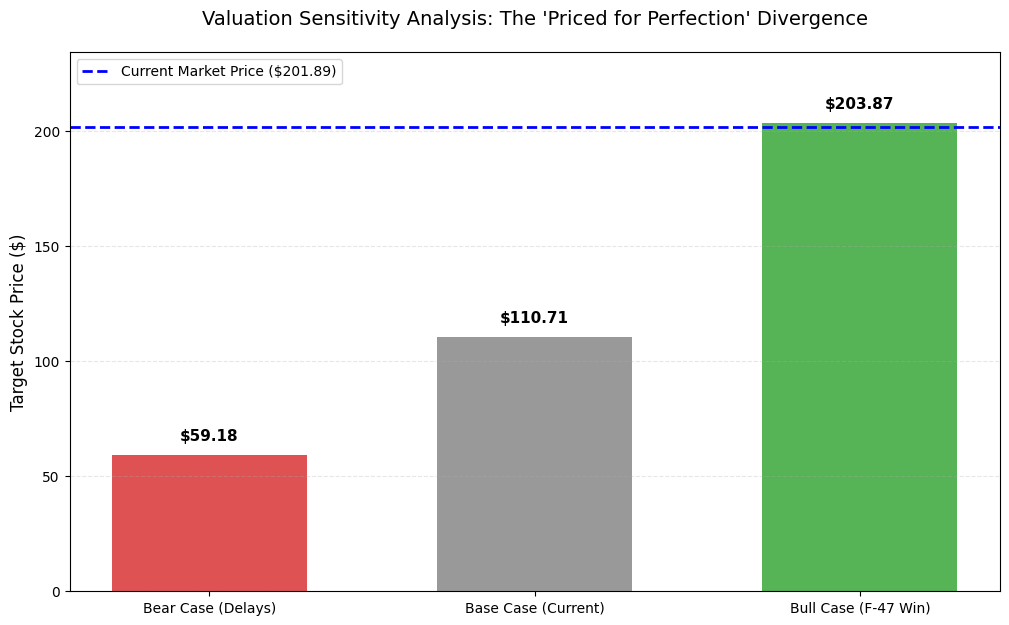

In [18]:
# [Cell 7] Scenario Sensitivity Analysis (Chart & Data Table Combined)

import matplotlib.pyplot as plt

# --- 1. Define Core Calculation Function (Supports Margin Adjustment) ---
def calculate_scenario_value(g_assumption, beta_assumption, margin_multiplier=1.0):
    """
    g_assumption: Perpetual growth rate
    beta_assumption: Systematic risk
    margin_multiplier: Cash flow adjustment factor (simulates high/low margins in bull/bear cases)
    """
    # Recalculate Ke and WACC (based on scenario Beta)
    sc_ke = risk_free_rate + beta_assumption * (MARKET_RETURN - risk_free_rate)
    sc_wacc = (w_e * sc_ke) + (w_d * cost_of_debt * (1 - TAX_RATE))

    # Adjust future cash flows (simulating margin changes)
    # Bull Case: margin_multiplier > 1.0
    # Bear Case: margin_multiplier < 1.0
    sc_future_fcfs = [fcf * margin_multiplier for fcf in future_fcfs]

    # Recalculate Terminal Value
    sc_last_fcf = sc_future_fcfs[-1]
    # Safety check: prevent negative denominator
    if sc_wacc <= g_assumption:
        return 0, sc_wacc # Error handling

    sc_tv = (sc_last_fcf * (1 + g_assumption)) / (sc_wacc - g_assumption)

    # Discounting - Bring future cash to today
    # 1. Present Value of Terminal Value
    sc_pv_tv = sc_tv / ((1 + sc_wacc) ** PROJECTION_YEARS)
    # 2. Present Value of Forecasted Cash Flows
    sc_pv_fcfs = sum([fcf / ((1+sc_wacc)**(i+1)) for i, fcf in enumerate(sc_future_fcfs)])

    # Calculate Equity Value
    sc_eq_val = (sc_pv_fcfs + sc_pv_tv) + cash_equivalents - total_debt
    target_price = sc_eq_val / shares_outstanding

    return target_price, sc_wacc

# --- 2. Define Scenario Parameter Configurations ---
scenarios_config = [
    {"Name": "Bear Case (Delays)",  "g": 0.025, "beta": 1.45, "margin_mult": 0.9, "color": "#d62728"}, # Red
    {"Name": "Base Case (Current)", "g": TERMINAL_GROWTH_RATE, "beta": beta, "margin_mult": 1.0, "color": "grey"},
    {"Name": "Bull Case (F-47 Win)", "g": 0.045, "beta": 1.05, "margin_mult": 1.2, "color": "#2ca02c"} # Green
]

# --- 3. Execute Calculations ---
results_data = []
plot_names = []
plot_prices = []
plot_colors = []

for sc in scenarios_config:
    price, calc_wacc = calculate_scenario_value(sc["g"], sc["beta"], sc["margin_mult"])

    upside = (price - current_price) / current_price

    # Collect data for table
    results_data.append({
        "Scenario": sc["Name"],
        "Beta Input": sc["beta"],
        "Growth (g)": f"{sc['g']:.1%}",
        "Implied WACC": f"{calc_wacc:.2%}",
        "Target Price": price,
        "Current Price": current_price,
        "Upside/Downside": upside
    })

    # Collect data for plot
    plot_names.append(sc["Name"])
    plot_prices.append(price)
    plot_colors.append(sc["color"])

# --- 4. Display Data Table ---
scenario_df = pd.DataFrame(results_data)

# Color highlighting function
def highlight_upside(val):
    color = 'green' if val > 0 else 'red'
    return f'color: {color}; font-weight: bold'

print("【F-47 Project Impact: Detailed Scenario Data Table】")
display(scenario_df.style.format({
    "Target Price": "${:,.2f}",
    "Current Price": "${:,.2f}",
    "Upside/Downside": "{:+.2%}"
}).map(highlight_upside, subset=['Upside/Downside']))

# --- 5. Display Visualization Chart ---
print("\n")
plt.figure(figsize=(12, 7)) # Adjust canvas size
bars = plt.bar(plot_names, plot_prices, color=plot_colors, alpha=0.8, width=0.6)

# Add current stock price reference line
plt.axhline(y=current_price, color='blue', linestyle='--', linewidth=2, label=f'Current Market Price (${current_price:.2f})')

# Chart decorations
plt.title("Valuation Sensitivity Analysis: The 'Priced for Perfection' Divergence", fontsize=14, pad=20)
plt.ylabel("Target Stock Price ($)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Annotate values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5,
             f"${yval:.2f}",
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Set Y-axis range, leaving space at the top
plt.ylim(0, max(plot_prices) * 1.15)

plt.show()